In [ ]:
#!pip3 install tensorflow
import os
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model  

%matplotlib inline

# For accessing the dataset, the directory where the dataset is located in the machine has to be specified in the below.

In [1]:
!python3 -V
# import tensorflow as tf
# os.getcwd()  # for accessing the current directory

Python 3.7.9


In [1]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [3012]:
train_x = np.zeros((8000, 64, 64, 3))

In [3013]:
train_y = np.zeros((8000,1))

In [3014]:
for i in range(4000):
    img = cv2.imread("cat." + str(i + 1) + ".jpg")
    train_x[(i*2),:,:,:] = cv2.resize(img, (64, 64))
    img = cv2.imread("dog." + str(i + 1) + ".jpg")
    train_x[(i*2 + 1),:,:,:] = cv2.resize(img, (64, 64))

In [3015]:
train_x.shape

(8000, 64, 64, 3)

In [3016]:
for i in range(4000):
    train_y[(i*2), 0] = 1
    train_y[(i*2 + 1), 0] = 0

In [3017]:
m_train = 8000

In [3018]:
# Reshape the training and test examples

train_x_flatten = train_x.reshape(m_train, -1).T

In [3019]:
train_x_flatten.shape

(12288, 8000)

In [3020]:
train_set_y = train_y.T

In [3021]:
train_set_y.shape

(1, 8000)

In [3022]:
train_set_x = train_x_flatten/255.

In [3023]:
train_set_x.shape

(12288, 8000)

In [3024]:
n_x = train_set_x.shape[0]     # num_px * num_px * 3
n_h = 10
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [3025]:
def initialize_parameters_deep(layer_dims, param):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    if (param == 0):
        parameters = {}
        L = len(layer_dims)            # number of layers in the network

        for l in range(1, L):
            np.random.seed(0)
            parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
            parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
    else:
        parameters = param

        
    return parameters

In [3026]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A)+b
    
    cache = (A, W, b)
    
    return Z, cache

In [3027]:
def softmax(x):
    """Calculates the softmax for each row of the input x.

    Your code should work for a row vector and also for matrices of shape (m,n).

    Argument:
    x -- A numpy matrix of shape (m,n)

    Returns:
    s -- A numpy matrix equal to the softmax of x, of shape (m,n)
    """
    
    ### START CODE HERE ### (≈ 3 lines of code)
    # Apply exp() element-wise to x. Use np.exp(...).
    x_exp = np.exp(x)

    # Create a vector x_sum that sums each row of x_exp. Use np.sum(..., axis = 1, keepdims = True).
    x_sum = np.sum(x_exp, axis=1, keepdims=True)
    
    # Compute softmax(x) by dividing x_exp by x_sum. It should automatically use numpy broadcasting.
    s = x_exp/x_sum

    ### END CODE HERE ###
    
    return s

In [3028]:
def sigmoid(Z):
  z = np.asarray(Z)
  a1 = (1 + np.exp(-z))
  a = np.divide(1, a1)
  return a, Z

In [3029]:
def relu(Z):
  r = Z.shape[0]
  c = Z.shape[1]
  zero = np.zeros((r,c))
  a = np.maximum(zero,Z)
  return a, Z  

In [3030]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

In [3031]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
  
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b' + str(l)],"relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],"sigmoid")
    caches.append(cache)
            
    return AL, caches

In [3032]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    logprobs = np.multiply(np.log(AL), Y) + np.multiply((1 - Y), np.log(1 - AL))
    cost = -(1/m)*np.sum(logprobs)
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return cost

In [3033]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward m_trainpropagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m*np.dot(dZ,A_prev.T)
    db =  1/m*(np.sum(dZ,axis=1, keepdims=True))
    dA_prev = np.dot(W.T,dZ)
  

    
    return dA_prev, dW, db

In [3034]:
def relu_backward(dA, z):
  deriv1 = np.where(z < 0, z, 1)
  deriv = np.where(deriv1 > 0, deriv1, 0)
  dz = np.multiply(dA, deriv)
  return dz

In [3035]:
def sigmoid_backward(dA, z):
  a, z_out = sigmoid(z)
  deriv = np.multiply(a, (1 - a))
  dz = np.multiply(dA, deriv)
  return dz

In [3036]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    return dA_prev, dW, db

In [3037]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")
  
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+2)],current_cache,"relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [3038]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network
    for i in range(1,L+1):
        parameters["W" + str(i)] = parameters["W" + str(i)] - learning_rate*grads["dW"+str(i)]
        parameters["b" + str(i)] = parameters["b" + str(i)] - learning_rate*grads["db"+str(i)]

    return parameters

In [3039]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, param = 0):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims, param)
 
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
       
        AL, caches = L_model_forward(X,parameters)
        
      
        # Compute cost.
        cost = compute_cost(AL,Y)
       
    
        # Backward propagation.
    
        grads = L_model_backward(AL,Y,caches)
    
 
        # Update parameters.
  
        parameters = update_parameters(parameters,grads,learning_rate)
   
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [3040]:
def L_layer_model_with_entropy(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, Rset = 0.3, param = 0):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims, param)
 
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
       
        AL, caches = L_model_forward(X,parameters)
        
      
        # Compute cost.
        logprobs = np.multiply(np.log(AL), Y) + np.multiply((1 - Y), np.log(1 - AL))
        L_low  = (1/(1 - Rset))*(np.sum(logprobs[Y == 0]))
        L_high = (1/Rset)*(np.sum(logprobs[Y == 1]))
        cost = -(1/X.shape[1])*(L_low + L_high)
        cost = np.squeeze(cost)   # error function or loss function or cost function
    
        # Backward propagation.
    
        grads = L_model_backward(AL,Y,caches)
    
 
        # Update parameters.
  
        parameters = update_parameters(parameters,grads,learning_rate)
   
                
        # Print the cost every 50 training example
        if print_cost and i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 50 == 0:
            costs.append(cost)
    
    # calculating entropy

    entropy = np.multiply(np.log(AL), AL) + np.multiply((1 - AL), np.log(1 - AL))        


    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, entropy

# For 256 neuron per layer Fully Connected Layer

In [3041]:
# initialization
Rset = 0.3
mini = 1000
iteration = 200
weights = 0
adaptive_threshold = 0.7
accuracy_non_pruned = []
accuracy_pruned = []
batch = [1, 2, 3, 4, 5, 6, 7, 8]

Cost after iteration 0: 1.644377
Cost after iteration 50: 1.650534
Cost after iteration 100: 1.653804
Cost after iteration 150: 1.655824


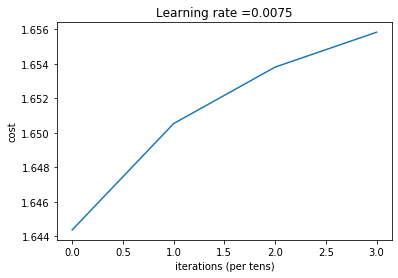

 indi = 500
Model: "sequential_523"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1569 (Conv2D)         (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1569 (MaxPooli (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1570 (Conv2D)         (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1570 (MaxPooli (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1571 (Conv2D)         (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1571 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_523 (Flatten)        (None, 2304

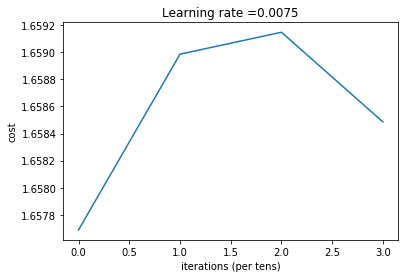

 indi = 500
Model: "sequential_525"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1575 (Conv2D)         (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1575 (MaxPooli (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1576 (Conv2D)         (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1576 (MaxPooli (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1577 (Conv2D)         (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1577 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_525 (Flatten)        (None, 2304

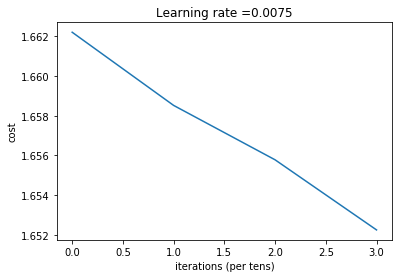

 indi = 500
Model: "sequential_527"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1581 (Conv2D)         (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1581 (MaxPooli (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1582 (Conv2D)         (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1582 (MaxPooli (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1583 (Conv2D)         (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1583 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_527 (Flatten)        (None, 2304

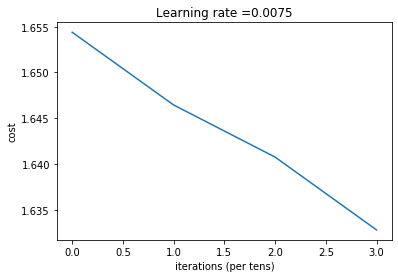

 indi = 500
Model: "sequential_529"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1587 (Conv2D)         (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1587 (MaxPooli (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1588 (Conv2D)         (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1588 (MaxPooli (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1589 (Conv2D)         (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1589 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_529 (Flatten)        (None, 2304

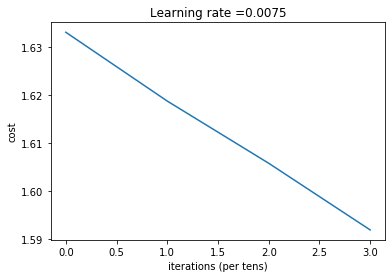

 indi = 853
Model: "sequential_531"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1593 (Conv2D)         (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1593 (MaxPooli (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1594 (Conv2D)         (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1594 (MaxPooli (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1595 (Conv2D)         (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1595 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_531 (Flatten)        (None, 2304

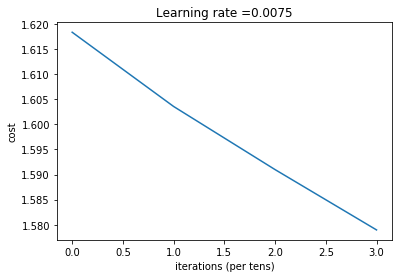

 indi = 646
Model: "sequential_533"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1599 (Conv2D)         (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1599 (MaxPooli (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1600 (Conv2D)         (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1600 (MaxPooli (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1601 (Conv2D)         (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1601 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_533 (Flatten)        (None, 2304

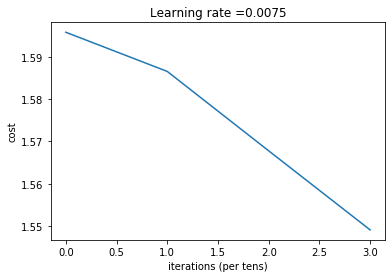

 indi = 500
Model: "sequential_535"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1605 (Conv2D)         (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1605 (MaxPooli (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1606 (Conv2D)         (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1606 (MaxPooli (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1607 (Conv2D)         (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1607 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_535 (Flatten)        (None, 2304

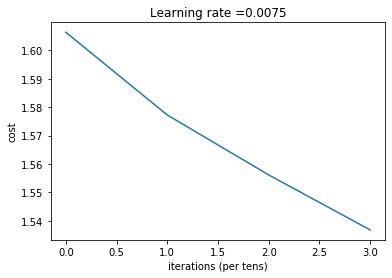

 indi = 500
Model: "sequential_537"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1611 (Conv2D)         (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1611 (MaxPooli (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1612 (Conv2D)         (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1612 (MaxPooli (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1613 (Conv2D)         (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1613 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_537 (Flatten)        (None, 2304

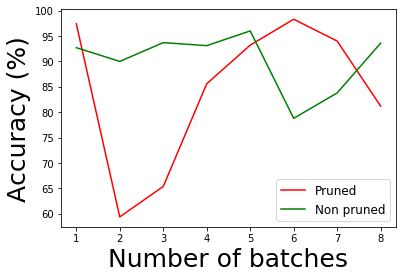

In [2991]:
# weight is initialized every time for each batch in CNN
for i in range(len(batch)):
    np.random.seed(0)
    start = i*mini
    end = (i + 1)*mini
    parameters, entropy = L_layer_model_with_entropy(train_set_x[:,start:end], train_set_y[:,start:end], layers_dims, num_iterations = iteration, print_cost=True, Rset= Rset, param = weights)
    weights = parameters
    entropy_threshold = st.median(entropy[0,:])
    y_pred, cache = L_model_forward(train_set_x[:,start:end], parameters)
    y_pred = np.where(y_pred > adaptive_threshold, y_pred, 0)
    y_pred = np.where(y_pred < adaptive_threshold, y_pred, 1)
    indi = []
    for i in range(mini):
        if entropy[0,i] < entropy_threshold:
            if(y_pred[0,i]):
                indi.append(i)
        else:
            indi.append(i)
    
    print(" indi = " + str(len(indi)) )
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>0.9):
                self.model.stop_training = True
    callbacks = myCallback()
    modelP = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 64x64 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
    ])
    modelP.summary()
    modelP.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
    historyP = modelP.fit(    x = train_x[indi,:,:,:],
                              y = train_y[indi,:],
                              steps_per_epoch=5,
                              epochs=30,
                              verbose=2,
                              callbacks=[callbacks])
    YP = modelP.predict(train_x[indi,:,:,:])
    y_actualP = np.where(YP > adaptive_threshold, YP, 0)
    y_actualP = np.where(y_actualP < adaptive_threshold, y_actualP, 1)       
    acc_pruned = (sum(y_actualP == train_y[indi])/ len(indi)) * 100
    accuracy_pruned.append(acc_pruned)
    
    print("acc_pruned = " + str(acc_pruned))
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
    ])
    model.summary()
    model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
    history = model.fit(      x = train_x[start:end,:,:,:],
                              y = train_y[start:end,:],
                              steps_per_epoch=5,
                              epochs=30,
                              verbose=2,
                              callbacks=[callbacks])
    Y = model.predict(train_x[start:end,:,:,:])
    y_actual = np.where(Y > adaptive_threshold, Y, 0)
    y_actual = np.where(y_actual < adaptive_threshold, y_actual, 1)
    acc_non_pruned = (sum(y_actual == train_y[start:end])/ mini) * 100
    accuracy_non_pruned.append(acc_non_pruned)
    
    print("acc_non_pruned = " + str(acc_non_pruned))
    
    y_predt = y_pred.T
    alpha1 = 1.1
    alpha2 = 1/alpha1

    Rth = np.sum(np.multiply(y_actualP, y_predt[indi])) / len(indi)
    if Rth > Rset:
        adaptive_threshold = alpha1 * adaptive_threshold
    else:
        adaptive_threshold = alpha2 * adaptive_threshold
    
    print("adaptive_threshold = " + str(adaptive_threshold))
# plotting pruning vs non-pruning accuracy
plt.plot(batch, accuracy_pruned, color='r', label='Pruned')
plt.plot(batch, accuracy_non_pruned, color='g', label='Non pruned')
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of batches')
#plt.title('accuracy for pruned and non-pruned data')
#plt.legend()
plt.legend(prop={"size":12})


axes = plt.gca()

axes.xaxis.label.set_size(25)
axes.yaxis.label.set_size(25)

plt.show()  

Cost after iteration 0: 1.644377
Cost after iteration 50: 1.650534
Cost after iteration 100: 1.653804
Cost after iteration 150: 1.655824


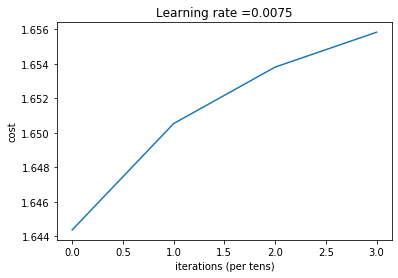

 indi = 500
Model: "sequential_547"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1641 (Conv2D)         (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1641 (MaxPooli (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1642 (Conv2D)         (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1642 (MaxPooli (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1643 (Conv2D)         (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1643 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_547 (Flatten)        (None, 2304

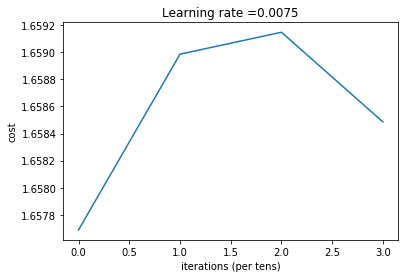

 indi = 500
Epoch 1/15
5/5 - 1s - loss: 10.6836 - accuracy: 0.5460
Epoch 2/15
5/5 - 0s - loss: 0.9750 - accuracy: 0.5760
Epoch 3/15
5/5 - 0s - loss: 0.5305 - accuracy: 0.7320
Epoch 4/15
5/5 - 0s - loss: 0.4606 - accuracy: 0.7740
Epoch 5/15
5/5 - 0s - loss: 0.3238 - accuracy: 0.8460
Epoch 6/15
5/5 - 0s - loss: 0.2405 - accuracy: 0.9160
INFO:tensorflow:Assets written to: pruned_model/assets
acc_pruned = [82.8]
Epoch 1/15
5/5 - 0s - loss: 10.0793 - accuracy: 0.5420
Epoch 2/15
5/5 - 0s - loss: 0.7720 - accuracy: 0.5590
Epoch 3/15
5/5 - 0s - loss: 0.5818 - accuracy: 0.6820
Epoch 4/15
5/5 - 0s - loss: 0.4960 - accuracy: 0.7570
Epoch 5/15
5/5 - 0s - loss: 0.5251 - accuracy: 0.7200
Epoch 6/15
5/5 - 0s - loss: 0.4544 - accuracy: 0.7920
Epoch 7/15
5/5 - 0s - loss: 0.4025 - accuracy: 0.8000
Epoch 8/15
5/5 - 0s - loss: 0.4261 - accuracy: 0.7950
Epoch 9/15
5/5 - 0s - loss: 0.3078 - accuracy: 0.8690
Epoch 10/15
5/5 - 0s - loss: 0.3695 - accuracy: 0.8190
Epoch 11/15
5/5 - 0s - loss: 0.3251 - accuracy

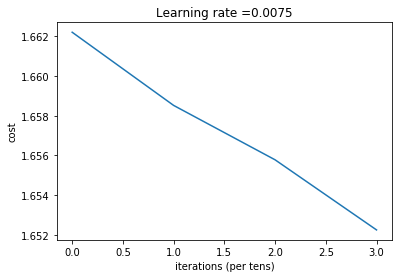

 indi = 500
Epoch 1/15
5/5 - 0s - loss: 7.6178 - accuracy: 0.5360
Epoch 2/15
5/5 - 0s - loss: 0.8651 - accuracy: 0.6520
Epoch 3/15
5/5 - 0s - loss: 0.4143 - accuracy: 0.8220
Epoch 4/15
5/5 - 0s - loss: 0.3197 - accuracy: 0.8660
Epoch 5/15
5/5 - 0s - loss: 0.3571 - accuracy: 0.8740
Epoch 6/15
5/5 - 0s - loss: 0.4435 - accuracy: 0.8080
Epoch 7/15
5/5 - 0s - loss: 0.4722 - accuracy: 0.7820
Epoch 8/15
5/5 - 0s - loss: 0.1792 - accuracy: 0.9380
INFO:tensorflow:Assets written to: pruned_model/assets
acc_pruned = [97.6]
Epoch 1/15
5/5 - 0s - loss: 4.3750 - accuracy: 0.5190
Epoch 2/15
5/5 - 0s - loss: 0.6894 - accuracy: 0.5840
Epoch 3/15
5/5 - 0s - loss: 0.6625 - accuracy: 0.6110
Epoch 4/15
5/5 - 0s - loss: 0.5384 - accuracy: 0.7160
Epoch 5/15
5/5 - 0s - loss: 0.4433 - accuracy: 0.7960
Epoch 6/15
5/5 - 0s - loss: 0.4963 - accuracy: 0.7340
Epoch 7/15
5/5 - 0s - loss: 0.4527 - accuracy: 0.7690
Epoch 8/15
5/5 - 0s - loss: 1.3572 - accuracy: 0.6330
Epoch 9/15
5/5 - 0s - loss: 0.8817 - accuracy: 0.

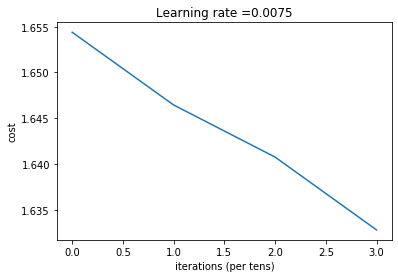

 indi = 500
Epoch 1/15
5/5 - 0s - loss: 4.6873 - accuracy: 0.6080
Epoch 2/15
5/5 - 0s - loss: 1.2331 - accuracy: 0.6320
Epoch 3/15
5/5 - 0s - loss: 0.3963 - accuracy: 0.8320
Epoch 4/15
5/5 - 0s - loss: 0.5788 - accuracy: 0.7940
Epoch 5/15
5/5 - 0s - loss: 0.3283 - accuracy: 0.8360
Epoch 6/15
5/5 - 0s - loss: 0.2015 - accuracy: 0.9160
INFO:tensorflow:Assets written to: pruned_model/assets
acc_pruned = [95.4]
Epoch 1/15
5/5 - 0s - loss: 1.7314 - accuracy: 0.5540
Epoch 2/15
5/5 - 0s - loss: 0.8346 - accuracy: 0.5360
Epoch 3/15
5/5 - 0s - loss: 0.6479 - accuracy: 0.5860
Epoch 4/15
5/5 - 0s - loss: 0.6122 - accuracy: 0.6350
Epoch 5/15
5/5 - 0s - loss: 0.7191 - accuracy: 0.6020
Epoch 6/15
5/5 - 0s - loss: 0.5846 - accuracy: 0.6670
Epoch 7/15
5/5 - 0s - loss: 0.5672 - accuracy: 0.7000
Epoch 8/15
5/5 - 0s - loss: 0.6233 - accuracy: 0.6480
Epoch 9/15
5/5 - 0s - loss: 0.4977 - accuracy: 0.7380
Epoch 10/15
5/5 - 0s - loss: 0.4523 - accuracy: 0.7730
Epoch 11/15
5/5 - 0s - loss: 0.6849 - accuracy: 

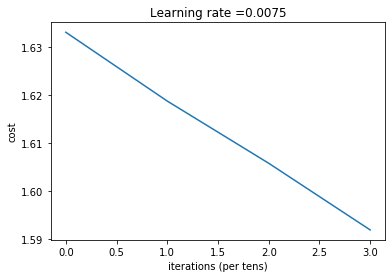

 indi = 853
Epoch 1/15
5/5 - 0s - loss: 8.3258 - accuracy: 0.5885
Epoch 2/15
5/5 - 0s - loss: 1.3811 - accuracy: 0.5662
Epoch 3/15
5/5 - 0s - loss: 0.4558 - accuracy: 0.8019
Epoch 4/15
5/5 - 0s - loss: 0.5381 - accuracy: 0.7397
Epoch 5/15
5/5 - 0s - loss: 0.2816 - accuracy: 0.8992
Epoch 6/15
5/5 - 0s - loss: 0.3621 - accuracy: 0.8253
Epoch 7/15
5/5 - 0s - loss: 0.1380 - accuracy: 0.9625
INFO:tensorflow:Assets written to: pruned_model/assets
acc_pruned = [98.71043376]
Epoch 1/15
5/5 - 0s - loss: 1.2750 - accuracy: 0.5380
Epoch 2/15
5/5 - 0s - loss: 0.6050 - accuracy: 0.6570
Epoch 3/15
5/5 - 0s - loss: 0.5612 - accuracy: 0.6820
Epoch 4/15
5/5 - 0s - loss: 0.4705 - accuracy: 0.7560
Epoch 5/15
5/5 - 0s - loss: 0.3890 - accuracy: 0.8300
Epoch 6/15
5/5 - 0s - loss: 0.3746 - accuracy: 0.7990
Epoch 7/15
5/5 - 0s - loss: 0.5057 - accuracy: 0.7170
Epoch 8/15
5/5 - 0s - loss: 0.2631 - accuracy: 0.8920
Epoch 9/15
5/5 - 0s - loss: 0.2630 - accuracy: 0.8800
Epoch 10/15
5/5 - 0s - loss: 0.3580 - accu

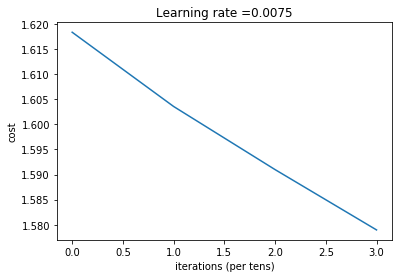

 indi = 646
Epoch 1/15
5/5 - 0s - loss: 11.7477 - accuracy: 0.6316
Epoch 2/15
5/5 - 0s - loss: 0.5052 - accuracy: 0.7895
Epoch 3/15
5/5 - 0s - loss: 0.2693 - accuracy: 0.9009
INFO:tensorflow:Assets written to: pruned_model/assets
acc_pruned = [94.73684211]
Epoch 1/15
5/5 - 0s - loss: 1.1511 - accuracy: 0.5580
Epoch 2/15
5/5 - 0s - loss: 0.6471 - accuracy: 0.6360
Epoch 3/15
5/5 - 0s - loss: 0.5878 - accuracy: 0.6780
Epoch 4/15
5/5 - 0s - loss: 0.6963 - accuracy: 0.6670
Epoch 5/15
5/5 - 0s - loss: 0.8165 - accuracy: 0.6040
Epoch 6/15
5/5 - 0s - loss: 0.4847 - accuracy: 0.7580
Epoch 7/15
5/5 - 0s - loss: 0.4763 - accuracy: 0.7440
Epoch 8/15
5/5 - 0s - loss: 0.3576 - accuracy: 0.8500
Epoch 9/15
5/5 - 0s - loss: 0.4456 - accuracy: 0.7650
Epoch 10/15
5/5 - 0s - loss: 0.3025 - accuracy: 0.8890
Epoch 11/15
5/5 - 0s - loss: 0.4183 - accuracy: 0.8110
Epoch 12/15
5/5 - 0s - loss: 0.4278 - accuracy: 0.7860
Epoch 13/15
5/5 - 0s - loss: 0.1848 - accuracy: 0.9440
INFO:tensorflow:Assets written to: no

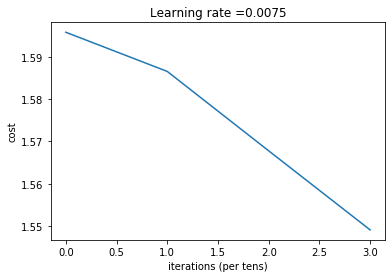

 indi = 500
Epoch 1/15
5/5 - 0s - loss: 3.7540 - accuracy: 0.5840
Epoch 2/15
5/5 - 0s - loss: 0.4411 - accuracy: 0.8100
Epoch 3/15
5/5 - 0s - loss: 0.3346 - accuracy: 0.8620
Epoch 4/15
5/5 - 0s - loss: 0.1743 - accuracy: 0.9540
INFO:tensorflow:Assets written to: pruned_model/assets
acc_pruned = [94.2]
Epoch 1/15
5/5 - 0s - loss: 1.3399 - accuracy: 0.5690
Epoch 2/15
5/5 - 0s - loss: 0.6117 - accuracy: 0.6650
Epoch 3/15
5/5 - 0s - loss: 0.6711 - accuracy: 0.6440
Epoch 4/15
5/5 - 0s - loss: 0.5991 - accuracy: 0.6680
Epoch 5/15
5/5 - 0s - loss: 0.4803 - accuracy: 0.7680
Epoch 6/15
5/5 - 0s - loss: 0.4001 - accuracy: 0.8220
Epoch 7/15
5/5 - 0s - loss: 0.4994 - accuracy: 0.7840
Epoch 8/15
5/5 - 0s - loss: 0.4582 - accuracy: 0.7630
Epoch 9/15
5/5 - 0s - loss: 0.2501 - accuracy: 0.9160
INFO:tensorflow:Assets written to: nonpruned_model/assets
acc_non_pruned = [95.6]
adaptive_threshold = 0.5259203606311044
Cost after iteration 0: 1.606371
Cost after iteration 50: 1.577272
Cost after iteration 1

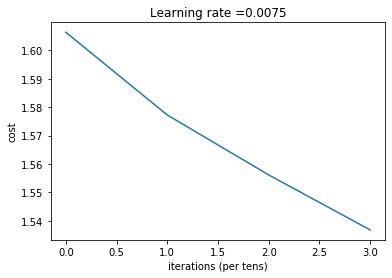

 indi = 668
Epoch 1/15
5/5 - 0s - loss: 4.1390 - accuracy: 0.5973
Epoch 2/15
5/5 - 0s - loss: 0.3688 - accuracy: 0.8249
Epoch 3/15
5/5 - 0s - loss: 0.2251 - accuracy: 0.9132
INFO:tensorflow:Assets written to: pruned_model/assets
acc_pruned = [97.15568862]
Epoch 1/15
5/5 - 0s - loss: 1.2380 - accuracy: 0.5480
Epoch 2/15
5/5 - 0s - loss: 0.6073 - accuracy: 0.6760
Epoch 3/15
5/5 - 0s - loss: 0.4965 - accuracy: 0.7500
Epoch 4/15
5/5 - 0s - loss: 0.6228 - accuracy: 0.6660
Epoch 5/15
5/5 - 0s - loss: 0.3892 - accuracy: 0.8260
Epoch 6/15
5/5 - 0s - loss: 0.3395 - accuracy: 0.8440
Epoch 7/15
5/5 - 0s - loss: 0.3606 - accuracy: 0.8270
Epoch 8/15
5/5 - 0s - loss: 0.3682 - accuracy: 0.8410
Epoch 9/15
5/5 - 0s - loss: 0.1914 - accuracy: 0.9390
INFO:tensorflow:Assets written to: nonpruned_model/assets
acc_non_pruned = [96.9]
adaptive_threshold = 0.5785123966942148


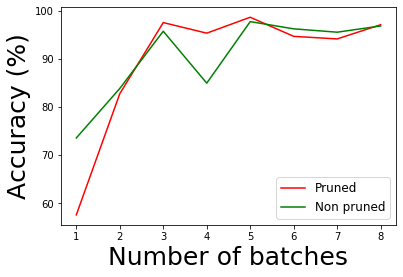

In [3042]:
# weight passes to next batch after first iteration in CNN
for i in range(len(batch)):
    np.random.seed(0)
    start = i*mini
    end = (i + 1)*mini
    parameters, entropy = L_layer_model_with_entropy(train_set_x[:,start:end], train_set_y[:,start:end], layers_dims, num_iterations = iteration, print_cost=True, Rset= Rset, param = weights)
    weights = parameters
    entropy_threshold = st.median(entropy[0,:])
    y_pred, cache = L_model_forward(train_set_x[:,start:end], parameters)
    y_pred = np.where(y_pred > adaptive_threshold, y_pred, 0)
    y_pred = np.where(y_pred < adaptive_threshold, y_pred, 1)
    indi = []
    for j in range(mini):
        if entropy[0,j] < entropy_threshold:
            if(y_pred[0,j]):
                indi.append(j)
        else:
            indi.append(j)
    
    print(" indi = " + str(len(indi)) )
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>0.9):
                self.model.stop_training = True
    callbacks = myCallback()
    if i == 0:
        modelP = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2), 
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(256, activation='relu'), 
            tf.keras.layers.Dense(1, activation='sigmoid')  
        ])
        modelP.summary()
        modelP.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
        
        historyP = modelP.fit(x = train_x[indi,:,:,:],
                              y = train_y[indi,:],
                              steps_per_epoch=5,
                              epochs=15,
                              verbose=2,
                              callbacks=[callbacks])
        modelP.save('pruned_model')
        modelP.save_weights('pruned_model_weights.h5')
    else:
        modelP=load_model('pruned_model')
        modelP.load_weights('pruned_model_weights.h5')
        historyP = modelP.fit(x = train_x[indi,:,:,:],
                              y = train_y[indi,:],
                              steps_per_epoch=5,
                              epochs=15,
                              verbose=2,
                              callbacks=[callbacks])
        modelP.save('pruned_model')
        modelP.save_weights('pruned_model_weights.h5')
    YP = modelP.predict(train_x[indi,:,:,:])
    y_actualP = np.where(YP > adaptive_threshold, YP, 0)
    y_actualP = np.where(y_actualP < adaptive_threshold, y_actualP, 1)       
    acc_pruned = (sum(y_actualP == train_y[indi])/ len(indi)) * 100
    accuracy_pruned.append(acc_pruned)
    
    print("acc_pruned = " + str(acc_pruned))
    
    if i == 0:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2), 
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(256, activation='relu'), 
            tf.keras.layers.Dense(1, activation='sigmoid')  
        ])
        model.summary()
        model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
        
        history = model.fit(  x = train_x[start:end,:,:,:],
                              y = train_y[start:end,:],
                              steps_per_epoch=5,
                              epochs=15,
                              verbose=2,
                              callbacks=[callbacks])
        model.save('nonpruned_model')
        model.save_weights('nonpruned_model_weights.h5')
    else:
        model=load_model('nonpruned_model')
        model.load_weights('nonpruned_model_weights.h5')        
        history = model.fit(  x = train_x[start:end,:,:,:],
                              y = train_y[start:end,:],
                              steps_per_epoch=5,
                              epochs=15,
                              verbose=2,
                              callbacks=[callbacks])
        model.save('nonpruned_model')
        model.save_weights('nonpruned_model_weights.h5')
    Y = model.predict(train_x[start:end,:,:,:])
    y_actual = np.where(Y > adaptive_threshold, Y, 0)
    y_actual = np.where(y_actual < adaptive_threshold, y_actual, 1)
    acc_non_pruned = (sum(y_actual == train_y[start:end])/ mini) * 100
    accuracy_non_pruned.append(acc_non_pruned)
    
    print("acc_non_pruned = " + str(acc_non_pruned))
    
    y_predt = y_pred.T
    alpha1 = 1.1
    alpha2 = 1/alpha1

    Rth = np.sum(np.multiply(y_actualP, y_predt[indi])) / len(indi)
    if Rth > Rset:
        adaptive_threshold = alpha1 * adaptive_threshold
    else:
        adaptive_threshold = alpha2 * adaptive_threshold
    
    print("adaptive_threshold = " + str(adaptive_threshold))
# plotting pruning vs non-pruning accuracy
plt.plot(batch, accuracy_pruned, color='r', label='Pruned')
plt.plot(batch, accuracy_non_pruned, color='g', label='Non pruned')
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of batches')
#plt.title('accuracy for pruned and non-pruned data')
#plt.legend()
plt.legend(prop={"size":12})


axes = plt.gca()

axes.xaxis.label.set_size(25)
axes.yaxis.label.set_size(25)

plt.show() 

# For 512 neuron per layer Fully Connected Layer

In [2874]:
# initialization
iteration = 200
weights = 0
adaptive_threshold = 0.7
accuracy_non_pruned = []
batch = [1, 2, 3, 4, 5, 6, 7, 8]

In [2891]:
mini = 1000

In [2893]:
# mini batch processing with 1000 training examples in 8 batches
np.random.seed(0)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
    ])
model.summary()
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
for j in range(15):
    for i in range(8):
        start = i*mini
        end = (i + 1)*mini
        history = model.fit(  x = train_x[start:end,:,:,:],
                              y = train_y[start:end,:],
                              #batch_size = 1000,
                              steps_per_epoch=1,
                              epochs=1,
                              verbose=1)
                              #callbacks=[callbacks])
Y = model.predict(train_x[0:8000,:,:,:])
y_actual = np.where(Y > adaptive_threshold, Y, 0)
y_actual = np.where(y_actual < adaptive_threshold, y_actual, 1)
acc_non_pruned = (sum(y_actual == train_y[0:8000])/ 8000) * 100
accuracy_non_pruned.append(acc_non_pruned)
    
print("acc_non_pruned = " + str(acc_non_pruned))
    

Model: "sequential_385"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1155 (Conv2D)         (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1155 (MaxPooli (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1156 (Conv2D)         (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1156 (MaxPooli (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1157 (Conv2D)         (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1157 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_385 (Flatten)        (None, 2304)           

In [2885]:
# whole batch processing with 8000 training examples 
start = 0 #i*mini
end = 8000 #(i + 1)*mini

np.random.seed(0)
    
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
    ])
model.summary()
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
history = model.fit(          x = train_x[start:end,:,:,:],
                              y = train_y[start:end,:],
                              #batch_size=8,
                              steps_per_epoch=5,
                              epochs=15,
                              verbose=2)
                              #callbacks=[callbacks])
Y = model.predict(train_x[start:end,:,:,:])
y_actual = np.where(Y > adaptive_threshold, Y, 0)
y_actual = np.where(y_actual < adaptive_threshold, y_actual, 1)
acc_non_pruned = (sum(y_actual == train_y[start:end])/ 8000) * 100
accuracy_non_pruned.append(acc_non_pruned)
    
print("acc_non_pruned = " + str(acc_non_pruned))

Model: "sequential_380"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1140 (Conv2D)         (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1140 (MaxPooli (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1141 (Conv2D)         (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1141 (MaxPooli (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1142 (Conv2D)         (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1142 (MaxPooli (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_380 (Flatten)        (None, 2304)           

# For each batch processing, the number of images in a batch as well as the labels should be put here

Cost after iteration 0: 1.564559
Cost after iteration 100: 1.506878


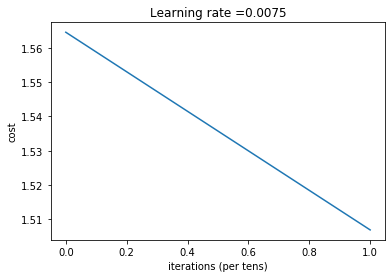

In [2630]:
parameters, entropy = L_layer_model_with_entropy(train_set_x[:,0:1000], train_set_y[:,0:1000], layers_dims, num_iterations = 200, print_cost=True, Rset= Rset, param = weights)

In [2631]:
parameters

{'W1': array([[-0.01065153, -0.0119019 ,  0.00779969, ...,  0.00604363,
          0.00717946, -0.02337969],
        [-0.00477214,  0.02180396,  0.00654883, ..., -0.00320164,
         -0.00451644, -0.00410152],
        [-0.00482205, -0.00241915, -0.01516668, ..., -0.00754185,
         -0.0001108 ,  0.01203509],
        ...,
        [ 0.03028458, -0.00137964, -0.01169357, ...,  0.00949348,
          0.00854537,  0.00488815],
        [ 0.00150552,  0.01175874, -0.01666489, ..., -0.01244362,
         -0.00088725,  0.00218366],
        [ 0.01327093, -0.01654713, -0.00550951, ..., -0.00532513,
         -0.01311427,  0.00530225]]), 'b1': array([[-4.16139645e-02],
        [-3.98605764e-03],
        [-4.29481392e-03],
        [ 3.72002136e-02],
        [ 5.61012683e-04],
        [-6.08608115e-03],
        [-5.82065147e-05],
        [ 8.66525517e-04],
        [-7.82475006e-04],
        [-2.76130239e-02]]), 'W2': array([[ 0.51525223,  0.37105869,  0.38582825, -0.41264236, -0.02886167,
          0

In [2632]:
weights = parameters

In [2633]:
weights

{'W1': array([[-0.01065153, -0.0119019 ,  0.00779969, ...,  0.00604363,
          0.00717946, -0.02337969],
        [-0.00477214,  0.02180396,  0.00654883, ..., -0.00320164,
         -0.00451644, -0.00410152],
        [-0.00482205, -0.00241915, -0.01516668, ..., -0.00754185,
         -0.0001108 ,  0.01203509],
        ...,
        [ 0.03028458, -0.00137964, -0.01169357, ...,  0.00949348,
          0.00854537,  0.00488815],
        [ 0.00150552,  0.01175874, -0.01666489, ..., -0.01244362,
         -0.00088725,  0.00218366],
        [ 0.01327093, -0.01654713, -0.00550951, ..., -0.00532513,
         -0.01311427,  0.00530225]]), 'b1': array([[-4.16139645e-02],
        [-3.98605764e-03],
        [-4.29481392e-03],
        [ 3.72002136e-02],
        [ 5.61012683e-04],
        [-6.08608115e-03],
        [-5.82065147e-05],
        [ 8.66525517e-04],
        [-7.82475006e-04],
        [-2.76130239e-02]]), 'W2': array([[ 0.51525223,  0.37105869,  0.38582825, -0.41264236, -0.02886167,
          0

In [2634]:
entropy.shape

(1, 1000)

In [2635]:
import statistics as st

In [2636]:
#entropy_sort = sorted(entropy)
entropy_threshold = st.median(entropy[0,:])

In [2637]:
entropy_threshold

-0.6227306157656278

# For each batch processing, the number of images in each batch should be put here 

In [2638]:
y_pred, cache = L_model_forward(train_set_x[:,0:1000], parameters)

In [2639]:
y_pred.shape

(1, 1000)

In [2640]:
y_pred = np.where(y_pred > adaptive_threshold, y_pred, 0)
y_pred = np.where(y_pred < adaptive_threshold, y_pred, 1)

In [2641]:
indi = []
for i in range(mini):
    if entropy[0,i] < entropy_threshold:
        if(y_pred[0,i]):
            indi.append(i)
    else:
        indi.append(i)

In [2642]:
#indi

In [2643]:
len(indi)

500

In [2645]:
import tensorflow as tf

# For 256 neuron per layer Fully Connected Layer

In [2648]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])
model.summary()

Model: "sequential_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_495 (Conv2D)          (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_495 (MaxPoolin (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_496 (Conv2D)          (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_496 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_497 (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_497 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_165 (Flatten)        (None, 2304)           

# For 512 neuron per layer Fully Connected Layer

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])
model.summary()

In [2647]:
model.summary()

Model: "sequential_164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_492 (Conv2D)          (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_492 (MaxPoolin (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_493 (Conv2D)          (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_493 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_494 (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_494 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_164 (Flatten)        (None, 2304)           

In [2649]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])


In [2650]:
history = model.fit(          x = train_x[indi,:,:,:],
                              y = train_y[indi,:],
                              steps_per_epoch=5,
                              epochs=15,
                              verbose=2)

Epoch 1/15
5/5 - 0s - loss: 61.6002 - accuracy: 0.5480
Epoch 2/15
5/5 - 0s - loss: 2.2673 - accuracy: 0.6360
Epoch 3/15
5/5 - 0s - loss: 1.1992 - accuracy: 0.6360
Epoch 4/15
5/5 - 0s - loss: 0.5186 - accuracy: 0.7740
Epoch 5/15
5/5 - 0s - loss: 0.4132 - accuracy: 0.8260
Epoch 6/15
5/5 - 0s - loss: 0.3570 - accuracy: 0.8480
Epoch 7/15
5/5 - 0s - loss: 0.3401 - accuracy: 0.8500
Epoch 8/15
5/5 - 0s - loss: 0.3805 - accuracy: 0.8200
Epoch 9/15
5/5 - 0s - loss: 0.4768 - accuracy: 0.8180
Epoch 10/15
5/5 - 0s - loss: 0.1686 - accuracy: 0.9640
Epoch 11/15
5/5 - 0s - loss: 0.2180 - accuracy: 0.9080
Epoch 12/15
5/5 - 0s - loss: 0.3979 - accuracy: 0.8360
Epoch 13/15
5/5 - 0s - loss: 0.6717 - accuracy: 0.8240
Epoch 14/15
5/5 - 0s - loss: 0.3113 - accuracy: 0.8560
Epoch 15/15
5/5 - 0s - loss: 0.1531 - accuracy: 0.9640


# For running the non-pruning data, the tensorflow model needs to be built again for non-pruning data.

In [2651]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])
model.summary()

Model: "sequential_166"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_498 (Conv2D)          (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_498 (MaxPoolin (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_499 (Conv2D)          (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_499 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_500 (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_500 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_166 (Flatten)        (None, 2304)           

In [2652]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [2717]:
# non pruning
history = model.fit(          x = train_x[0:1000,:,:,:],
                              y = train_y[0:1000,:],
                              steps_per_epoch=5,
                              epochs=15,
                              verbose=2)

Epoch 1/15
5/5 - 0s - loss: 63.2435 - accuracy: 0.5080
Epoch 2/15
5/5 - 0s - loss: 2.2442 - accuracy: 0.4730
Epoch 3/15
5/5 - 0s - loss: 1.5141 - accuracy: 0.5070
Epoch 4/15
5/5 - 0s - loss: 0.7764 - accuracy: 0.5950
Epoch 5/15
5/5 - 0s - loss: 0.7774 - accuracy: 0.5790
Epoch 6/15
5/5 - 0s - loss: 0.8351 - accuracy: 0.5590
Epoch 7/15
5/5 - 0s - loss: 0.5967 - accuracy: 0.6510
Epoch 8/15
5/5 - 0s - loss: 0.7550 - accuracy: 0.6060
Epoch 9/15
5/5 - 0s - loss: 1.4597 - accuracy: 0.5480
Epoch 10/15
5/5 - 0s - loss: 0.9568 - accuracy: 0.5510
Epoch 11/15
5/5 - 0s - loss: 0.5278 - accuracy: 0.7290
Epoch 12/15
5/5 - 0s - loss: 0.4504 - accuracy: 0.7800
Epoch 13/15
5/5 - 0s - loss: 0.4445 - accuracy: 0.7780
Epoch 14/15
5/5 - 0s - loss: 0.3634 - accuracy: 0.8480
Epoch 15/15
5/5 - 0s - loss: 0.6299 - accuracy: 0.6780


In [2572]:
Y = model.predict(train_x[indi,:,:,:])

In [2529]:
# non pruning
Y = model.predict(train_x[0:1000,:,:,:])

In [2573]:
Y.shape

(500, 1)

In [2574]:
adaptive_threshold = 0.7

In [2575]:
y_actual = np.where(Y > adaptive_threshold, Y, 0)
y_actual = np.where(y_actual < adaptive_threshold, y_actual, 1)

In [2576]:
y_predt = y_pred.T

In [2577]:
y_predt.shape

(1000, 1)

In [2578]:
np.sum(np.multiply(y_actual, y_predt[indi])) / len(indi)

0.27

In [2535]:
# non pruning
np.sum(np.multiply(y_actual, y_predt)) / mini

0.112

In [2579]:
alpha1 = 1.1
alpha2 = 1/alpha1

Rth = np.sum(np.multiply(y_actual, y_predt[indi])) / len(indi)
if Rth > Rset:
    adaptive_threshold = alpha1 * adaptive_threshold
else:
    adaptive_threshold = alpha2 * adaptive_threshold

In [2536]:
# non pruning
alpha1 = 1.1
alpha2 = 1/alpha1

Rth = np.sum(np.multiply(y_actual, y_predt)) / mini
if Rth > Rset:
    adaptive_threshold = alpha1 * adaptive_threshold
else:
    adaptive_threshold = alpha2 * adaptive_threshold

In [2441]:
adaptive_threshold

0.6363636363636364

In [2580]:
acc = (sum(y_actual == train_y[indi])/ len(indi)) * 100
acc

array([95.8])

In [2537]:
# non pruning
acc = (sum(y_actual == train_y[7000:8000])/ mini) * 100
acc

array([74.9])

In [191]:
accuracy = []

In [231]:
accuracy.append(acc)

In [2581]:
pruned = [93.2, 95.8, 90.2, 90.38, 97.21, 93.41, 92.2, 90.6]

In [2582]:
non_pruned = [84.7, 90.9, 83.8, 85.4, 93, 86.4, 80.7, 85.3]

In [2583]:
batch = [1, 2, 3, 4, 5, 6, 7, 8]

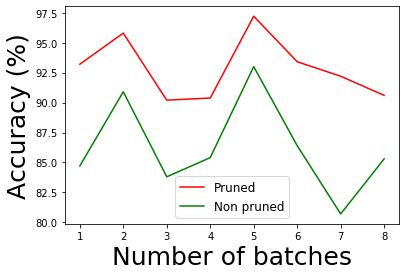

In [2595]:
 # plot the cost
plt.plot(batch, pruned, color='r', label='Pruned')
plt.plot(batch, non_pruned, color='g', label='Non pruned')
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of batches')
#plt.title('accuracy for pruned and non-pruned data')
#plt.legend()
plt.legend(prop={"size":12})


axes = plt.gca()

axes.xaxis.label.set_size(25)
axes.yaxis.label.set_size(25)

plt.show()